# Youbike History Data EDA

reference: https://github.com/pixnet/2018-pixnet-hackathon/blob/master/opendata/pmo.opendata.md

- youbike station vacancy data
- from: 2018/1/1
- to: 2018/6/15
- update frequency: 5 minute

In [0]:
pip install partd

  Created wheel for pprint: filename=pprint-0.1-cp36-none-any.whl size=1251 sha256=332d39ab0d5d9a6a2a7a5eb47e8f9719877181163d9f2278e7f9eb5cd407140d
  Stored in directory: /root/.cache/pip/wheels/42/d4/c6/16a6495aecc1bda5d5857bd036efd50617789ba9bea4a05124
Successfully built pprint


In [0]:
pip install dask --upgrade

     |████████████████████████████████| 798kB 3.4MB/s 
  Found existing installation: dask 2.9.2
    Uninstalling dask-2.9.2:
      Successfully uninstalled dask-2.9.2


## Get Data

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import dask.dataframe as dd
import dask.bag as db
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Load youbike history data into a dask.bag and transform it into a dask.dataframe

In [0]:
def get_youbike_history_data(to_dataframe=True, stop_no_subset=None):
  # convert text string to dictionary format
  def text_to_dict(text):
    text_list = text.split(',')
    return {
        field:val.strip()
        for (field, val) 
        in zip(FIELDS_LIST, text_list)
        if field in FIELDS_TO_KEEP
    }
      
  # only get data with stop_no inside stop_no_subset
  def get_data_in_stop_no_subset(data):
    return data['stop_no'] in stop_no_subset

  # constants    
  FIELDS_LIST = [
    'stop_no', 
    'stop_name', 
    'total_number', 
    'current_number', 
    'stop_area', 
    'update_time', 
    'lat', 
    'lng', 
    'address', 
    'stop_area_en', 
    'stop_name_en',
    'address_en',
    'vacancy_number',
    'status',
    'batch_update_time',
    'db_update_time',
    'update_info_time',
    'update_info_date'
  ]
  FIELDS_TO_KEEP = set([
      'stop_no',
      'stop_name',
      'stop_area',
      'lat',
      'lng',
      'total_number',
      'current_number',
      'vacancy_number',
      'status',
      'db_update_time'
  ])
  FIELDS_META = {
      'stop_no': np.str,
      'stop_name': np.str,
      'stop_area': np.str,
      'lat': np.str,
      'lng': np.str,
      'total_number': np.uint8,
      'current_number': np.uint8,
      'vacancy_number': np.uint8,
      'status': np.uint8,
      'db_update_time': np.str 
      # convert to datetime format later https://github.com/pandas-dev/pandas/issues/8004
  }
  FILEPATHS = [
    'drive/My Drive/youbike-history-data-1.csv.zip',
    'drive/My Drive/youbike-history-data-2.csv.zip'
  ]

  # dask.bag format
  b = (db.read_text(FILEPATHS)
        .map(text_to_dict))
  
  if stop_no_subset:
    b = b.filter(get_data_in_stop_no_subset)

  if to_dataframe:
    df = b.to_dataframe(meta=FIELDS_META)
    df['db_update_time'] = dd.to_datetime(df['db_update_time'])
    return df
  else:
    return b

## EDA

In [0]:
df.head()

In [0]:
df = get_youbike_history_data(stop_no_subset=['0304'])

,stop_no,stop_name,stop_area,lat,lng,total_number,current_number,vacancy_number,status,db_update_time
0,0304,金華公園,大安區,25.029902000000,121.531235000000,32,0,31,1,2018-04-30 15:55:00
1,0304,金華公園,大安區,25.029902000000,121.531235000000,32,12,20,1,2018-06-10 12:45:00
2,0304,金華公園,大安區,25.029902000000,121.531235000000,32,4,27,1,2018-04-30 21:50:00
3,0304,金華公園,大安區,25.029902000000,121.531235000000,32,29,3,1,2018-06-11 07:15:00
4,0304,金華公園,大安區,25.029902000000,121.531235000000,32,2,30,1,2018-06-12 17:40:00


In [0]:
df.dtypes

stop_no                   object
stop_name                 object
stop_area                 object
lat                       object
lng                       object
total_number               uint8
current_number             uint8
vacancy_number             uint8
status                     uint8
db_update_time    datetime64[ns]
dtype: object

In [0]:
df['status'].value_counts().compute()

1    43398
0       91
Name: status, dtype: int64

Choose stops that are enabled and group them by `stop_no` and sort them by `db_update_time`

In [0]:
df_by_stopno = (df[df['status'] == 1]
                  .groupby(by='stop_no')
                  .apply(lambda x: x.sort_values(
                      'db_update_time', ascending=True))
                  .set_index('stop_no'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df_by_stopno.head()

,stop_name,stop_area,lat,lng,total_number,current_number,vacancy_number,status,db_update_time
stop_no,,,,,,,,,
0304,金華公園,大安區,25.029902000000,121.531235000000,32,24,8,1,2018-01-02 00:05:00
0304,金華公園,大安區,25.029902000000,121.531235000000,32,25,7,1,2018-01-02 00:10:00
0304,金華公園,大安區,25.029902000000,121.531235000000,32,25,7,1,2018-01-02 00:15:00
0304,金華公園,大安區,25.029902000000,121.531235000000,32,25,7,1,2018-01-02 00:20:00
0304,金華公園,大安區,25.029902000000,121.531235000000,32,23,9,1,2018-01-02 00:25:00


In [0]:
df_by_stopno.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 9 entries, stop_name to db_update_time
dtypes: datetime64[ns](1), object(4), uint8(4)

In [0]:
df_by_stopno.describe().compute()

,total_number,current_number,vacancy_number,status
count,21446.0,21446.000000,21446.000000,21446.0
mean,32.0,15.939989,15.632519,1.0
std,0.0,7.593428,7.590280,0.0
min,32.0,0.000000,0.000000,1.0
25%,32.0,10.000000,9.000000,1.0
50%,32.0,17.000000,15.000000,1.0
75%,32.0,22.000000,22.000000,1.0
max,32.0,32.000000,32.000000,1.0


In [0]:
df_by_time = df_by_stopno.set_index('db_update_time')

In [0]:
df_by_time.head()

,stop_name,stop_area,lat,lng,total_number,current_number,vacancy_number,status
db_update_time,,,,,,,,
2018-01-02 00:05:00,金華公園,大安區,25.029902000000,121.531235000000,32,24,8,1
2018-01-02 00:10:00,金華公園,大安區,25.029902000000,121.531235000000,32,25,7,1
2018-01-02 00:15:00,金華公園,大安區,25.029902000000,121.531235000000,32,25,7,1
2018-01-02 00:20:00,金華公園,大安區,25.029902000000,121.531235000000,32,25,7,1
2018-01-02 00:25:00,金華公園,大安區,25.029902000000,121.531235000000,32,23,9,1


### Plot number of youbike available by month

In [0]:
df_M = df_by_time.resample('M').mean().compute()
df_M

,total_number,current_number,vacancy_number,status
db_update_time,,,,
2018-01-31,32.0,17.132201,14.728166,1.0
2018-02-28,32.0,15.857285,16.079065,1.0
2018-03-31,32.0,15.877111,16.069556,1.0
2018-04-30,32.0,15.431034,15.553941,1.0
2018-05-31,32.0,15.446594,15.490328,1.0
2018-06-30,32.0,15.907843,15.939869,1.0


In [0]:
x = df_M.index
y = df_M.current_number

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


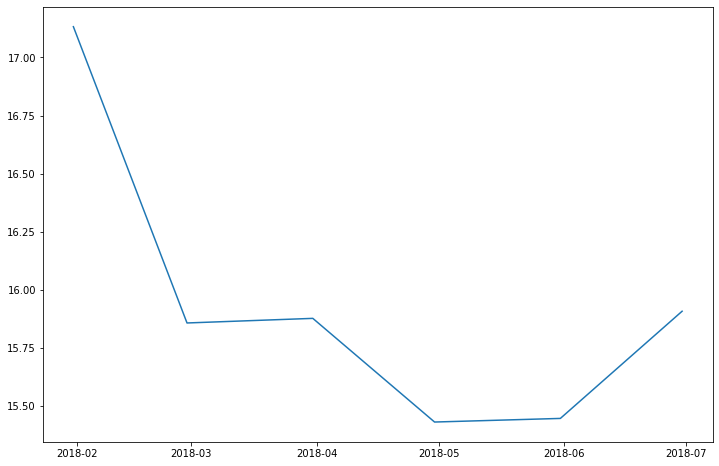

In [0]:
plt.figure(figsize=(12, 8));
plt.plot(x, y);

### Plot number of youbike available by day

In [0]:
df_D = df_by_time.resample('D').mean().compute()
df_D

,total_number,current_number,vacancy_number,status
db_update_time,,,,
2018-01-02,32.0,15.902439,15.801394,1.0
2018-01-03,32.0,21.301724,10.698276,1.0
2018-01-04,NaN,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN,NaN
2018-01-06,NaN,NaN,NaN,NaN
...,...,...,...,...
2018-06-10,32.0,18.392857,13.600000,1.0
2018-06-11,32.0,18.925373,13.067164,1.0
2018-06-12,32.0,15.247863,16.743590,1.0


In [0]:
x = df_D.index
y = df_D.current_number

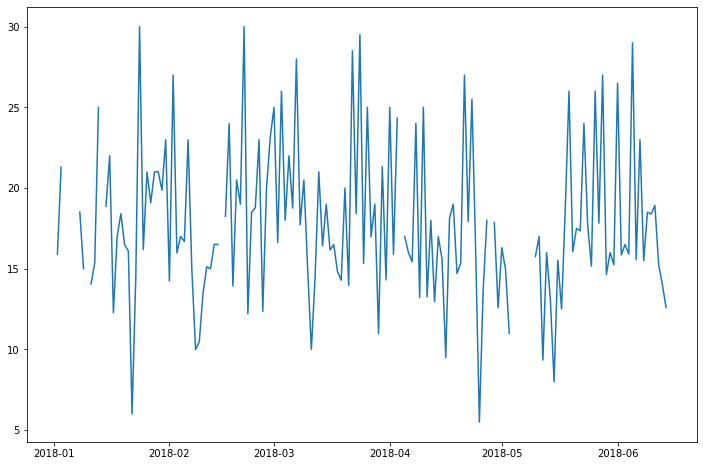

In [0]:
plt.figure(figsize=(12, 8));
plt.plot(x, y);

### Plot number of youbike available by hour

In [0]:
df_H = df_by_time.resample('H').mean().compute()
df_H

,total_number,current_number,vacancy_number,status
db_update_time,,,,
2018-01-02 00:00:00,32.0,24.363636,7.636364,1.0
2018-01-02 01:00:00,32.0,24.166667,7.833333,1.0
2018-01-02 02:00:00,32.0,24.166667,7.833333,1.0
2018-01-02 03:00:00,32.0,24.000000,8.000000,1.0
2018-01-02 04:00:00,32.0,24.000000,8.000000,1.0
...,...,...,...,...
2018-06-14 10:00:00,32.0,2.500000,29.500000,1.0
2018-06-14 11:00:00,32.0,4.571429,27.428571,1.0
2018-06-14 12:00:00,32.0,2.166667,29.833333,1.0


In [0]:
start_index = 0
number_of_days = 1
start = 24 * start_index
end = start + 24 * number_of_days
x = df_H.index[start:end]
y = df_H.current_number[start:end]

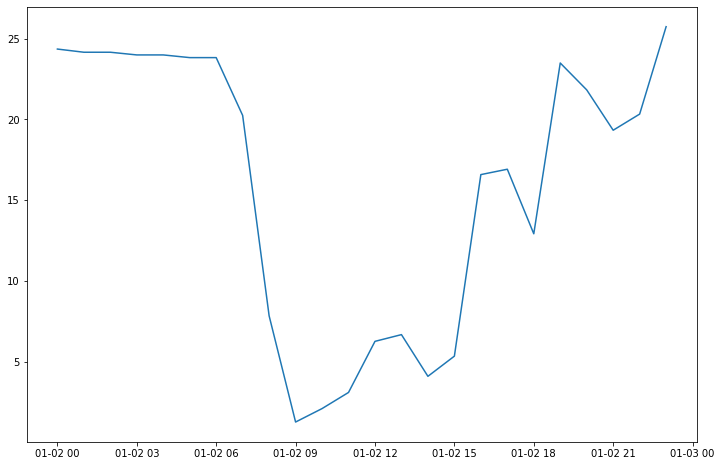

In [0]:
plt.figure(figsize=(12, 8));
plt.plot(x, y);